<a href="https://colab.research.google.com/github/AnoushaPawarCTRL/icebergsFYP/blob/main/Arctic2_0_U_net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Iceberg Segmentation using U-net.

# This notebook will demonstrate the use of U-net to segment icebergs from satellite imagery.
# This model will allow icebergs to be automatically deteceted and segmented so the area and coordinates are constantly being tracked and recorded without the need for manual interruption.
# The data can be used in a variety of ways such as to explore polar ice cap regression.

In [ ]:
# Google Drive
from google.colab import drive
import os

mount_point = '/content/drive'

# Ensure the mount point exists and is empty
if os.path.exists(mount_point) and os.listdir(mount_point):
    # If not empty, try to unmount if already mounted, or clear contents (use with caution)
    # For simplicity, we'll try to unmount if it's currently mounted and then mount again.
    # If files persist after unmount, a deeper cleanup or a different mount point might be needed.
    print(f"Mount point '{mount_point}' is not empty. Attempting to force unmount and remount...")
    try:
        drive.flush_and_unmount()
        # Optionally, remove any lingering directories if unmount failed to clear them
        # for item in os.listdir(mount_point):
        #     item_path = os.path.join(mount_point, item)
        #     if os.path.isdir(item_path): os.rmdir(item_path)
        #     else: os.remove(item_path)
        # print("Mount point cleaned.")
    except Exception as e:
        print(f"Could not unmount existing drive: {e}. Please ensure the mount point is clear manually if issues persist.")

drive.mount(mount_point, force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.4 MB/s eta 0:00:00


In [ ]:
import rasterio

#images are geotiff,preprocessed in QGIS to retain data

path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif"

with rasterio.open(path) as src:
    print("Is GeoTIFF:", src.crs is not None)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Width x Height:", src.width, "x", src.height)


Is GeoTIFF: True
CRS: EPSG:3031
Transform: | 495.72, 0.00,-2835398.93|
| 0.00,-495.72, 2195508.73|
| 0.00, 0.00, 1.00|
Width x Height: 1414 x 1470


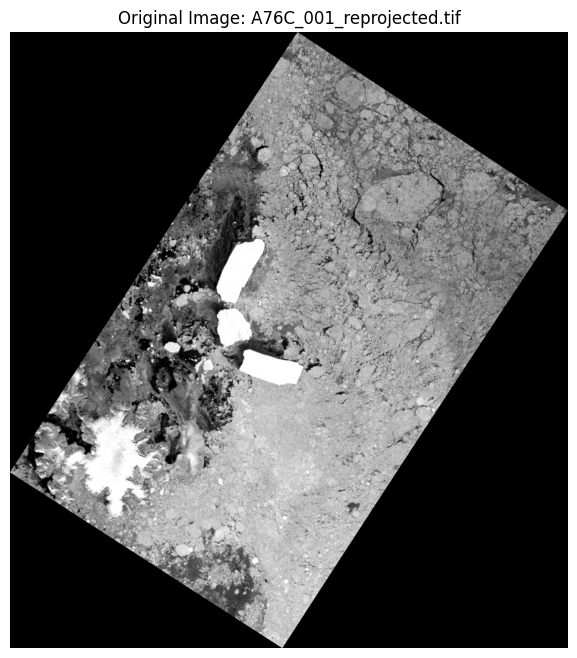

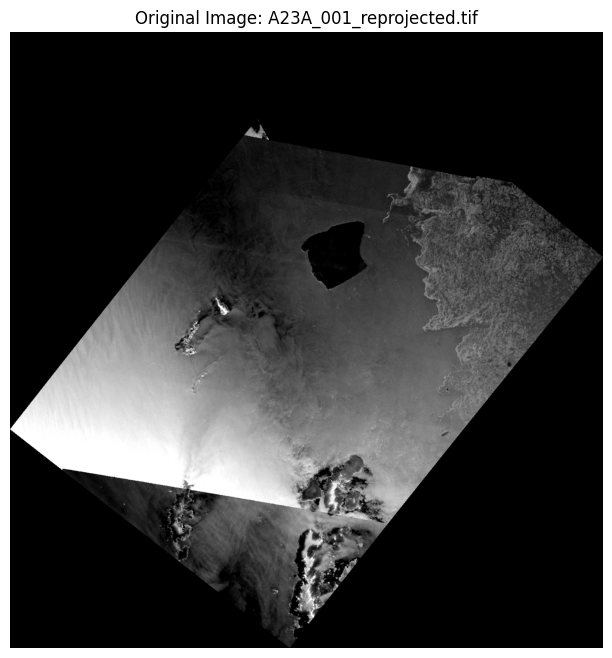

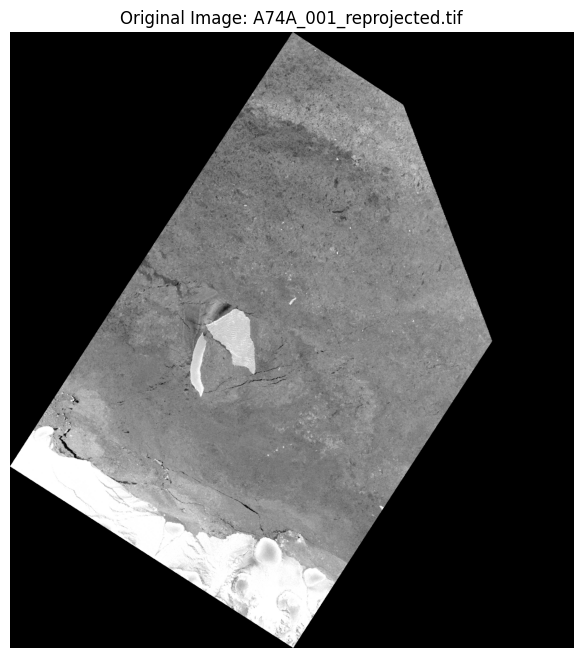

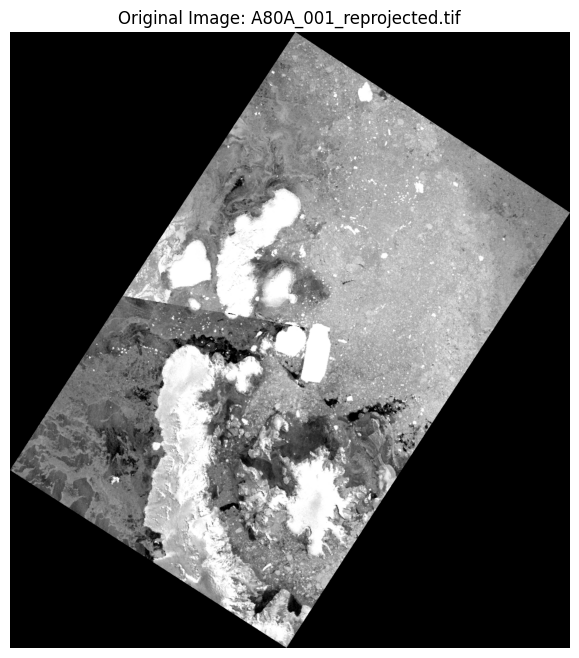

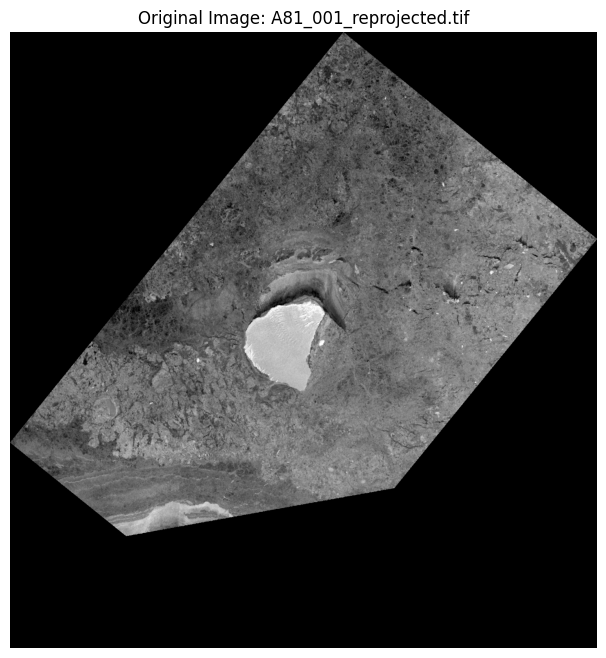

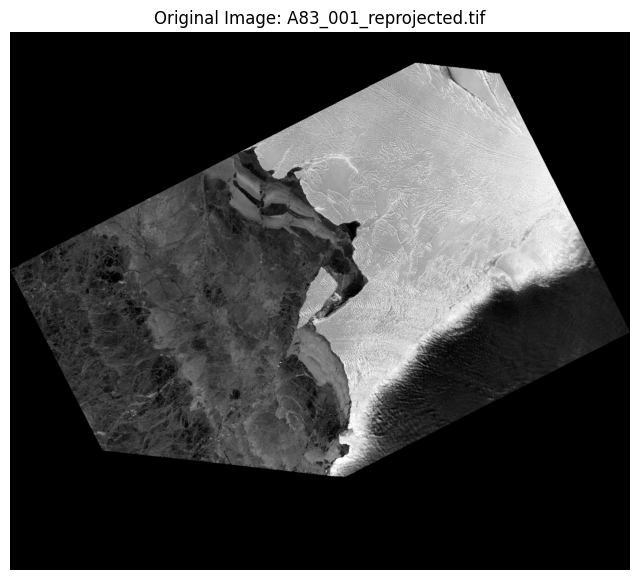

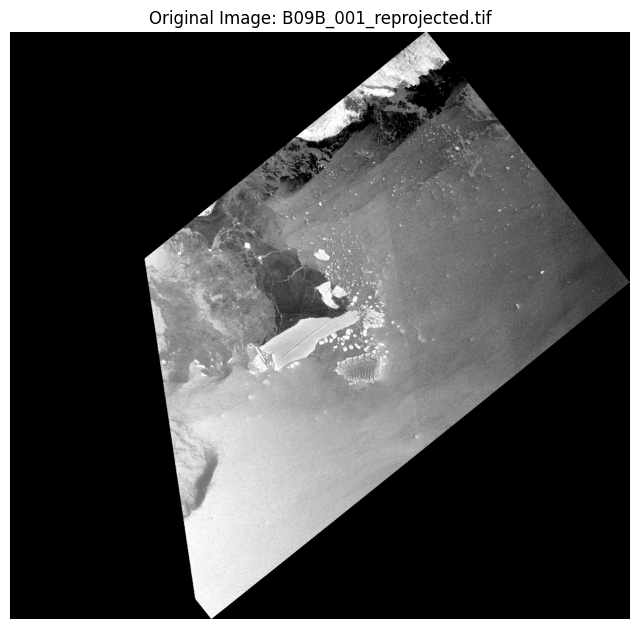

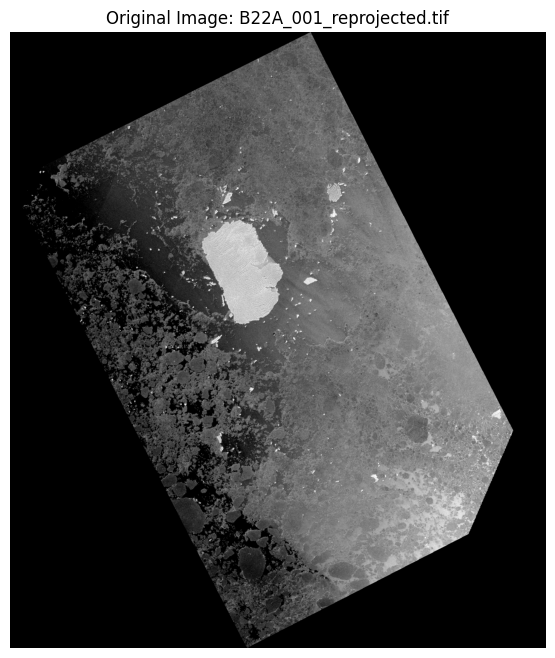

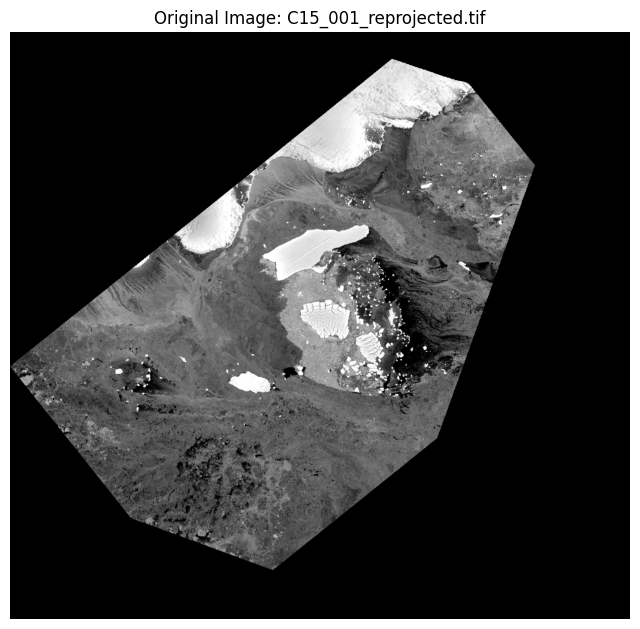

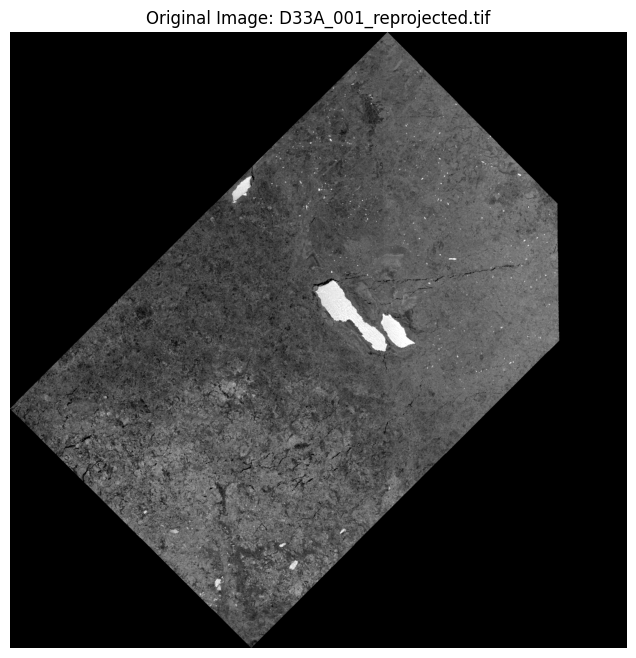

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

image_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"

# Get a list of all TIFF files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))]

# Display each image
for filename in image_files:
    img_path = os.path.join(image_folder, filename)

    with rasterio.open(img_path) as src:
        img_data = src.read(1)  # Read the first band

    plt.figure(figsize=(8, 8))
    plt.imshow(img_data, cmap='gray')
    plt.title(f"Original Image: {filename}")
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np
import rasterio

with rasterio.open("/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif") as src:
    img = src.read(1)

print("min:", np.min(img))
print("max:", np.max(img))


min: 0
max: 65535


In [ ]:
#iceberg images to be pre-processed to enhance the iceberg and create a better distinction


#speckle reduction
#edge enhancement using gradients (ocean is smoother than icebergs)
#Guassian water blur
#to remove speckle, using improved algorithm that combines lee and median filter depedant on the pixel being homogenous or very textured or inbetween(based in study)


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def lee_filter(img, size=5):
    """
    Classic Lee filter for SAR speckle reduction.
    Works well on Sentinel-1 intensity data.
    """
    img = img.astype(np.float32)

    # Window mean and variance
    mean = median_filter(img, size=size)
    mean_sq = median_filter(img**2, size=size)
    variance = mean_sq - mean**2

    overall_var = np.var(img)
    W = variance / (variance + overall_var + 1e-6)

    return mean + W * (img - mean)


def preprocess_sar(img):
    """
    SAFE preprocessing:
    - No dB conversion (keeps radiometric contrast stable)
    - Lee filter + median smooth
    - Stretch contrast (optional but recommended)
    """

    # Step 1: Lee speckle reduction
    img_lee = lee_filter(img, size=7)

    # Step 2: Median smoothing (helps suppress tiny noise)
    img_med = median_filter(img_lee, size=3)

    # Step 3: Contrast stretching to highlight icebergs
    low, high = np.percentile(img_med, (2, 98))
    img_stretch = np.clip((img_med - low) / (high - low + 1e-6), 0, 1)

    return img_stretch


def preprocess_and_save(original_folder, output_folder, preview_folder):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(preview_folder, exist_ok=True)

    for file in os.listdir(original_folder):
        if not file.lower().endswith(".tif"):
            continue

        input_path = os.path.join(original_folder, file)
        output_path = os.path.join(output_folder, file)

        print(f"Processing {file} ...")

        with rasterio.open(input_path) as src:
            img = src.read(1)            # Read intensity band
            meta = src.meta.copy()       # Preserve GeoTIFF metadata

        # Preprocess SAR intensity
        processed = preprocess_sar(img)

        # Save cleaned GeoTIFF (0–1 scaled)
        meta.update(dtype="float32")

        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(processed.astype(np.float32), 1)

        # Save PNG preview (side-by-side)
        preview_path = os.path.join(preview_folder, file.replace(".tif", ".png"))

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Processed")
        plt.imshow(processed, cmap="gray")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(preview_path, dpi=150)
        plt.close()

        print(f"Saved cleaned:   {output_path}")
        print(f"Saved preview:   {preview_path}\n")





In [ ]:
original_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"
output_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned"
preview_folder = "/content/drive/MyDrive/Antarctic_Icebergs/previews"

preprocess_and_save(original_folder, output_folder, preview_folder)


Processing A76C_001_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned/A76C_001_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews/A76C_001_reprojected.png

Processing A23A_001_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned/A23A_001_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews/A23A_001_reprojected.png

Processing A74A_001_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned/A74A_001_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews/A74A_001_reprojected.png

Processing A80A_001_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned/A80A_001_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews/A80A_001_reprojected.png

Processing A81_001_reprojected.tif ...
Saved cleaned:   /con

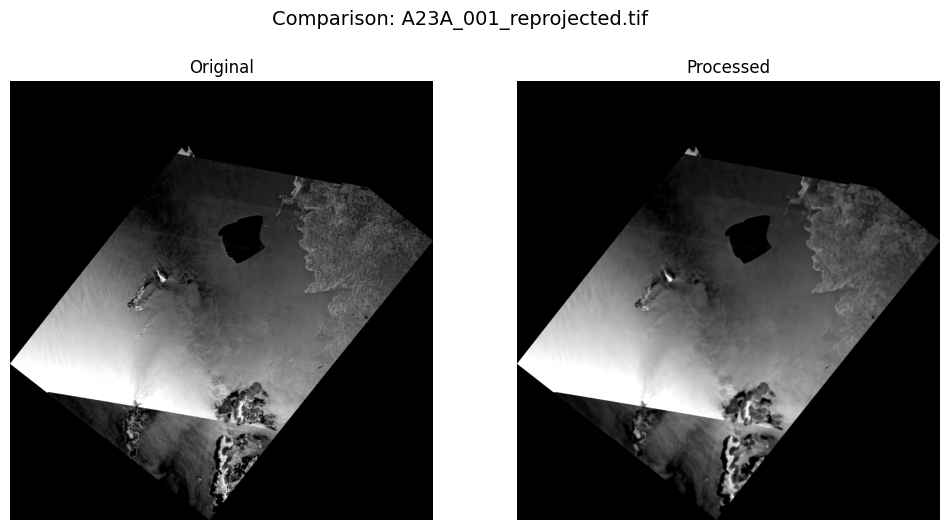

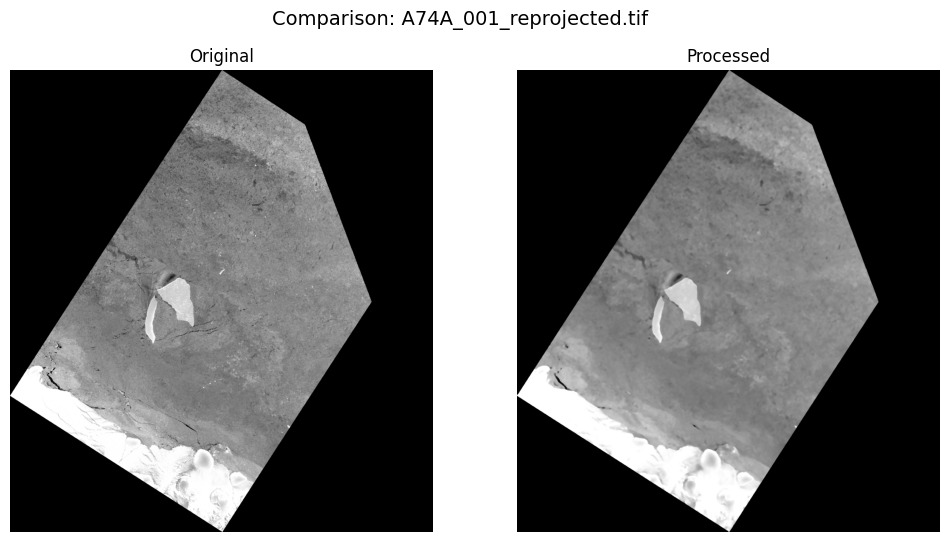

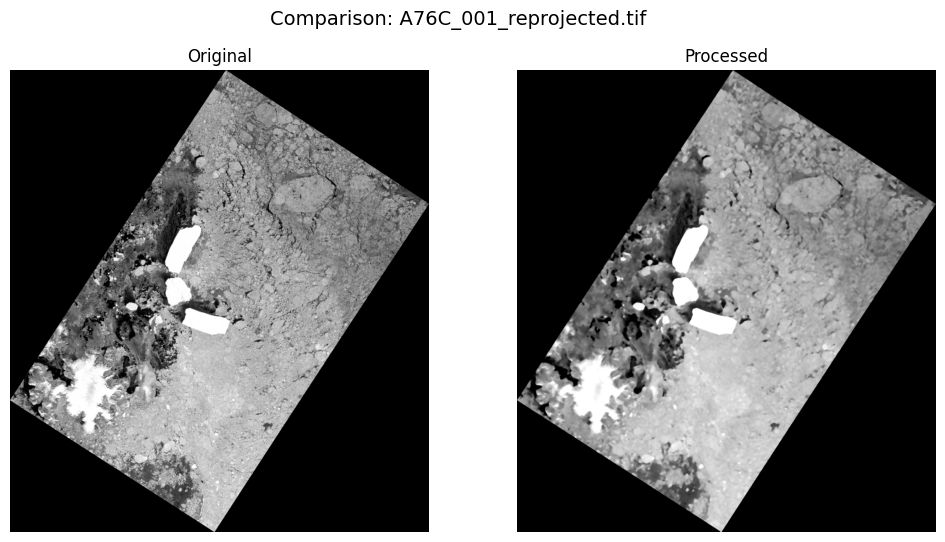

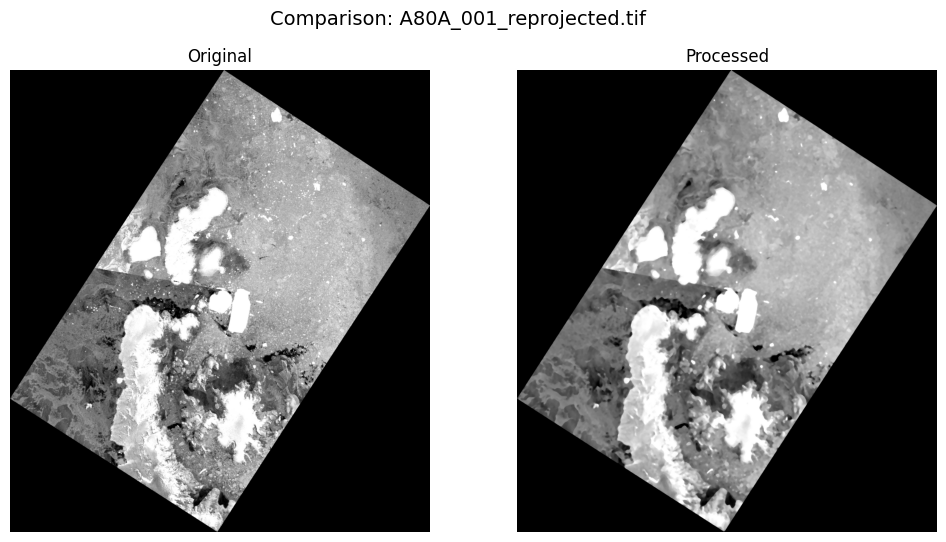

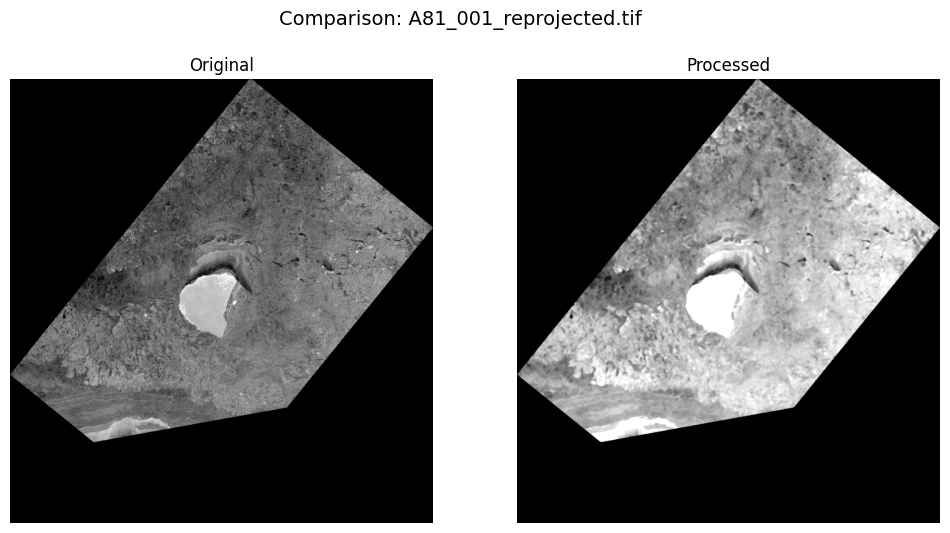

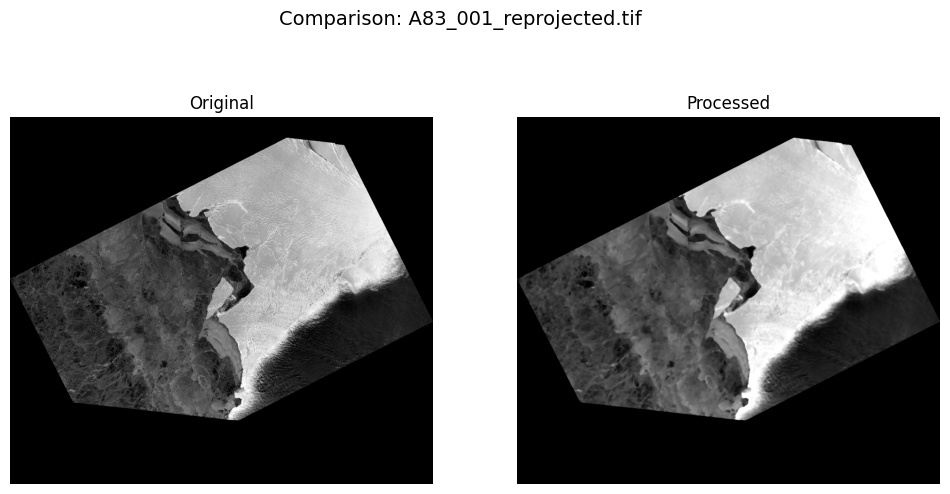

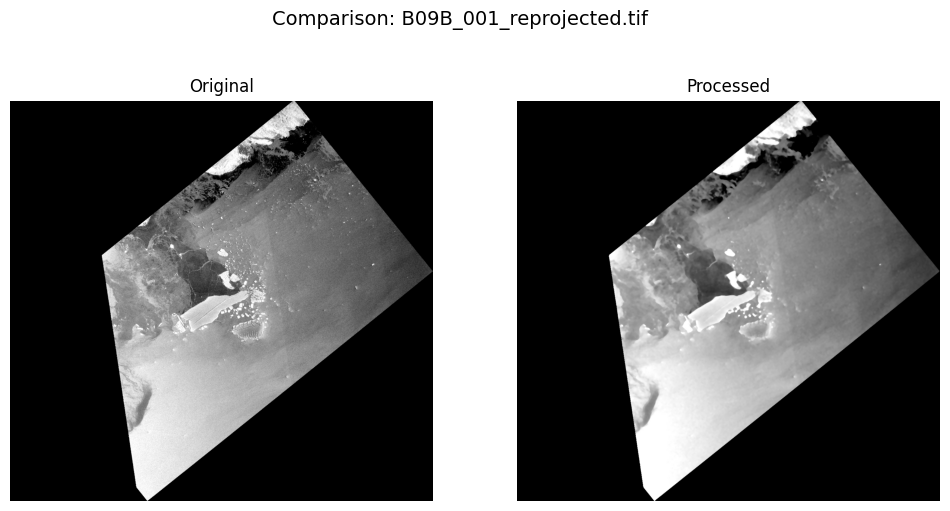

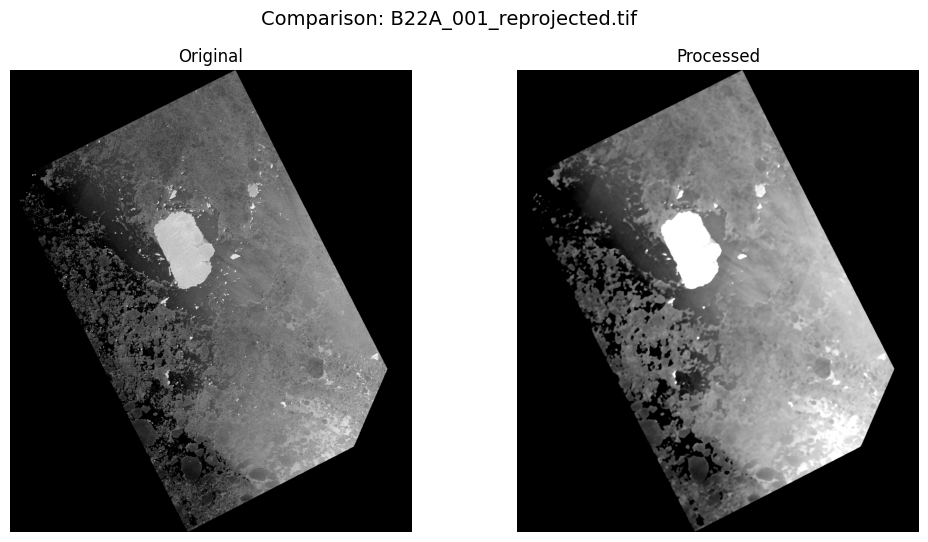

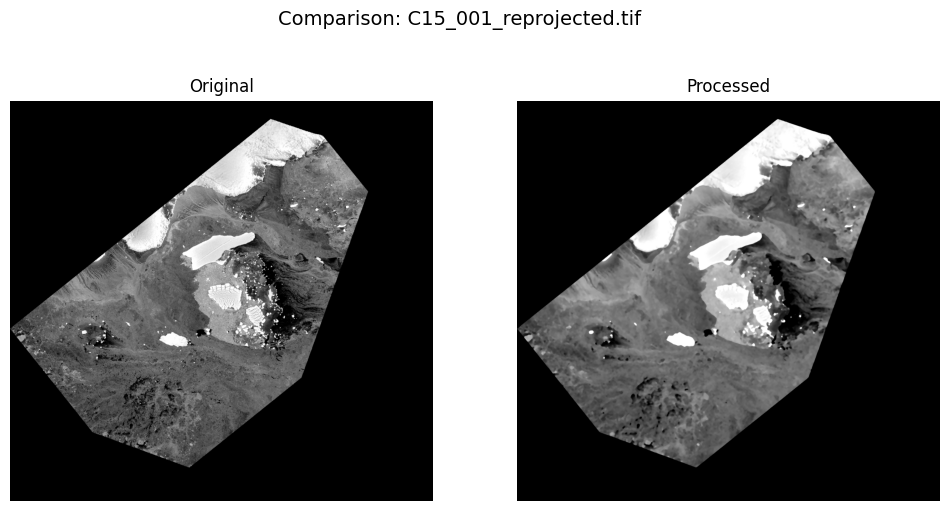

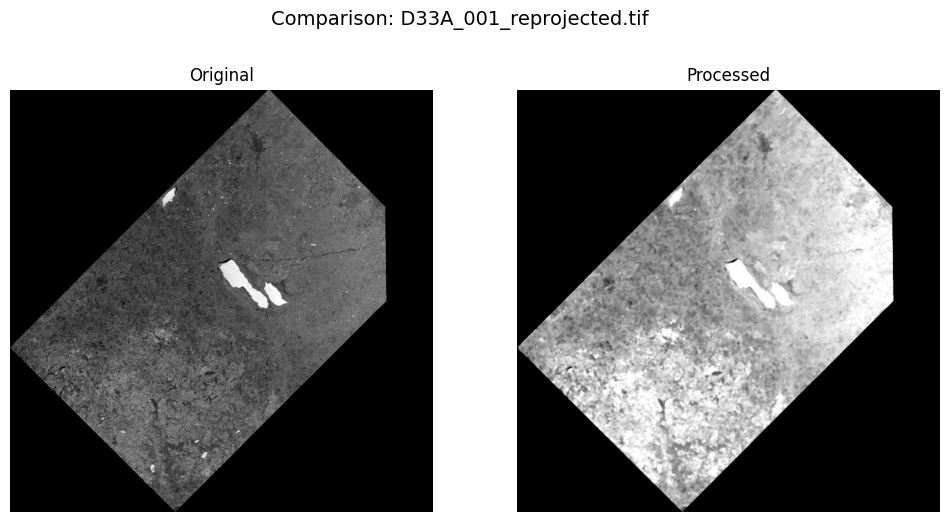

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt

original_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"
cleaned_folder   = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned"

# List only matching TIF files
files = sorted([f for f in os.listdir(original_folder) if f.lower().endswith(".tif")])

for f in files:
    orig_path = os.path.join(original_folder, f)
    clean_path = os.path.join(cleaned_folder, f)

    # Skip files that weren't processed
    if not os.path.exists(clean_path):
        print(f"Skipping (no cleaned file found): {f}")
        continue

    # Load both images
    with rasterio.open(orig_path) as src:
        orig = src.read(1)

    with rasterio.open(clean_path) as src:
        clean = src.read(1)

    # Show side-by-side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(orig, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Processed")
    plt.imshow(clean, cmap="gray")
    plt.axis("off")

    plt.suptitle(f"Comparison: {f}", fontsize=14)
    plt.show()


In [ ]:
# Convert masks to binary (0 or 1)
# Treat anything > 0 as iceberg
masks_binary = (masks > 0).astype(np.float32)


In [ ]:
print("Unique mask values:", np.unique(masks_binary))


Unique mask values: [0. 1.]


In [ ]:
import os

mask_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked"

print("Files in folder:")
for f in os.listdir(mask_folder):
    print(f)


Files in folder:
A76C_001_mask.tif
A23A_001_mask.tif
A74A_001_mask.tif
A80A_001_mask.tif
A81_001_mask.tif
A83_001_mask.tif
B09B_001_mask.tif
B22A_001_mask.tif
C15_001_mask.tif
D33A_001_mask.tif


In [ ]:
import cv2

mask_path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked/A23A_001_mask.tif"
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
print("Loaded mask:", mask)


Loaded mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(np.float64(-0.5), np.float64(1413.5), np.float64(1469.5), np.float64(-0.5))

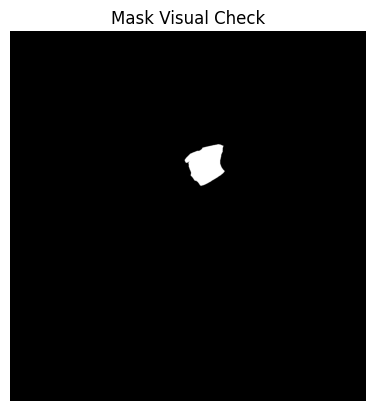

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

mask_path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked/A23A_001_mask.tif"

mask = np.array(Image.open(mask_path))

plt.imshow(mask, cmap='gray')
plt.title("Mask Visual Check")
plt.axis('off')


In [ ]:
import os
import cv2
import numpy as np

def binarize_masks(mask_folder):
    for filename in os.listdir(mask_folder):
        if not filename.endswith(".tif"):
            continue

        path = os.path.join(mask_folder, filename)
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print("❌ Could not read:", filename)
            continue

        # Normalize to 0–1
        mask_norm = mask / 255.0

        # Hard threshold
        mask_bin = (mask_norm > 0.5).astype(np.uint8)

        # Save back as binary (0 or 255 to view properly)
        mask_save = mask_bin * 255
        cv2.imwrite(path, mask_save)

        print("✔ Fixed:", filename)

# Run it
binarize_masks("/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked")


❌ Could not read: A76C_001_mask.tif
❌ Could not read: A23A_001_mask.tif
❌ Could not read: A74A_001_mask.tif
❌ Could not read: A80A_001_mask.tif
❌ Could not read: A81_001_mask.tif
❌ Could not read: A83_001_mask.tif
❌ Could not read: B09B_001_mask.tif
❌ Could not read: B22A_001_mask.tif
❌ Could not read: C15_001_mask.tif
❌ Could not read: D33A_001_mask.tif


In [ ]:
import os
import re
import rasterio
import cv2
import numpy as np

image_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_cleaned"
mask_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked"

def get_prefix(filename):
    """Extract the prefix (e.g., 'A23A') from the filename"""
    match = re.match(r'([A-Z]+\d+[A-Z]?)_', filename)
    return match.group(1) if match else None

def load_data(image_folder, mask_folder):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files  = sorted(os.listdir(mask_folder))

    for img_name, mask_name in zip(image_files, mask_files):

        img_path  = os.path.join(image_folder, img_name)
        mask_path = os.path.join(mask_folder, mask_name)

        # Load and resize image
        with rasterio.open(img_path) as src:
            img = src.read(1).astype(np.float32)
            img = cv2.resize(img, (256, 256))
            if img.max() > 1:
                img = img / 255.0  # Normalize image to [0, 1]

        # Load and resize mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            mask = cv2.resize(mask, (256, 256))
            if mask.max() > 1:
                mask = mask / 255.0  # Normalize mask to [0, 1]

            # Binarize mask: iceberg = 1, background = 0
            mask = np.where(mask > 0.5, 1.0, 0.0)

        images.append(np.expand_dims(img, -1))
        masks.append(np.expand_dims(mask, -1))

    return np.array(images), np.array(masks)

# Load the dataset
images, masks = load_data(image_folder, mask_folder)


In [ ]:
import numpy as np

def check_ranges(images, masks):
    print("📌 Images:")
    print("  min:", np.min(images))
    print("  max:", np.max(images))
    print("  mean:", np.mean(images))
    print("  dtype:", images.dtype)

    print("\n📌 Masks:")
    print("  min:", np.min(masks))
    print("  max:", np.max(masks))
    print("  mean:", np.mean(masks))
    print("  dtype:", masks.dtype)

    # Quick binary check for masks
    unique_vals = np.unique(masks)
    if not np.all((unique_vals == 0) | (unique_vals == 1)):
        print("\n❌ Masks are NOT binary. Unique values:", unique_vals)
    else:
        print("\n✅ Masks are binary (0 and 1 only).")

# Use it here
check_ranges(images, masks)


📌 Images:
  min: 0.0
  max: 1.0
  mean: 0.2636639
  dtype: float32

📌 Masks:
  min: 0.0
  max: 1.0
  mean: 0.0066864013671875
  dtype: float64

✅ Masks are binary (0 and 1 only).


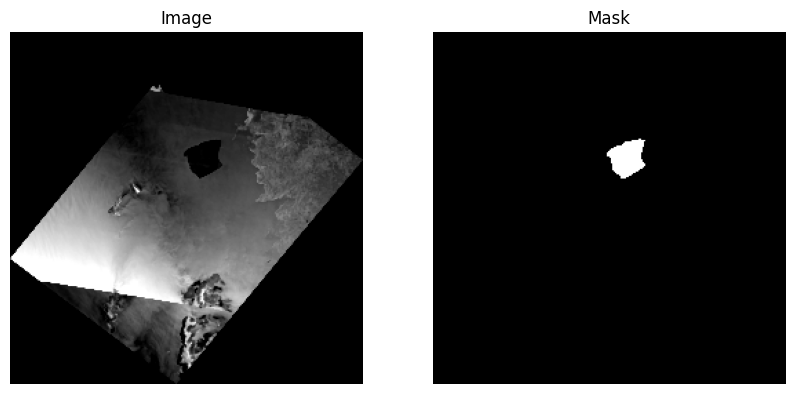

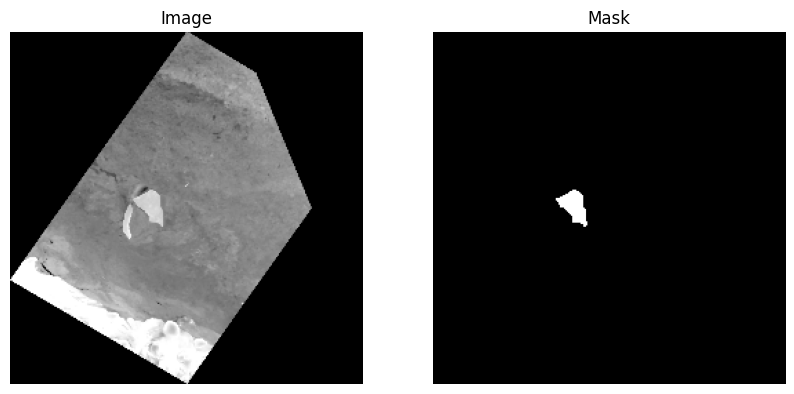

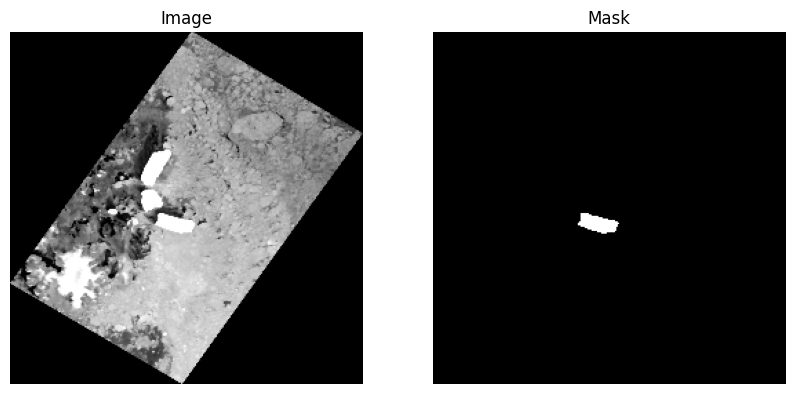

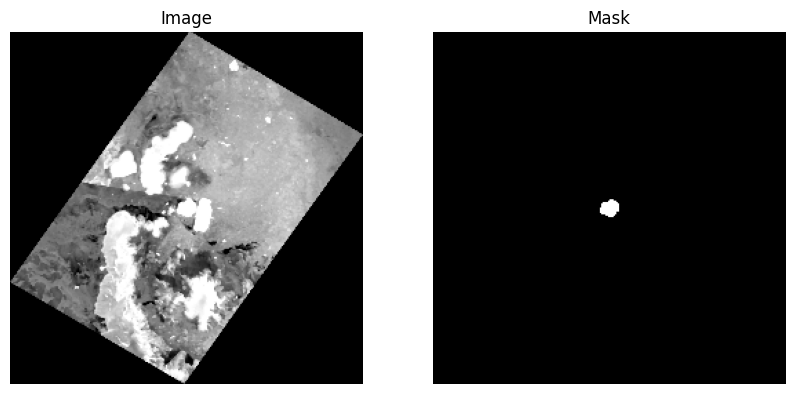

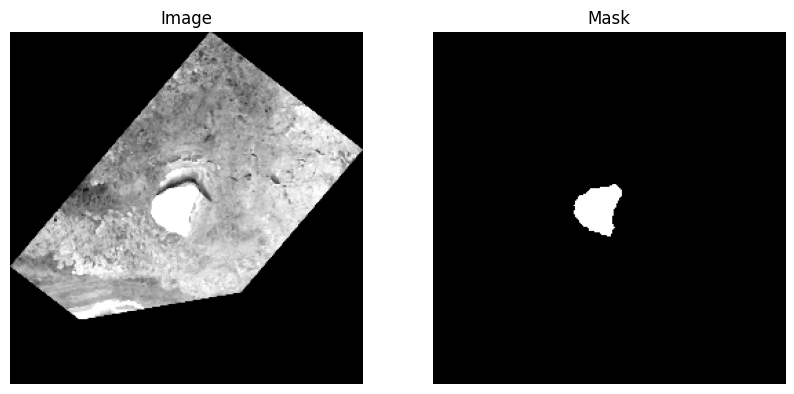

In [ ]:
import matplotlib.pyplot as plt

for i in range(min(5, len(images))):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(images[i].squeeze(), cmap='gray')
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(masks[i].squeeze(), cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# Here a standard u-net architecture has been used
def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder - a series of convolutional layers, starting by capturing larger features and increasing the filters in each block for deeper learning.
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bottleneck - bottom of the U, the bridge between the encoder and decoder. the highest number of filters without pooling to capture larger patterns.
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder - restore image to its original size
    up5 = UpSampling2D((2, 2))(conv4) # doubles spatial size
    merge5 = Concatenate()([conv3, up5]) # merges features - "skip connections" to keep fine spatial details that could be lost during pooling
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6) # back to original size
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7) # segmented mask prediction, sigmoid function means values closer to 1 indicate iceberg and 0 is non iceberg

    model = Model(inputs, outputs) # creates a single keras model
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adjusting the weights, measuring loss and acuracy.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# -------------------------------------------------------
# 1. Training/Validation Split
# -------------------------------------------------------

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, masks,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)



# -------------------------------------------------------
# 3. Compile the model
# -------------------------------------------------------

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# -------------------------------------------------------
# 4. Callbacks
# -------------------------------------------------------

checkpoint = ModelCheckpoint(
    "unet_best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)


# -------------------------------------------------------
# 5. Train the model
# -------------------------------------------------------

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=8,
    callbacks=[checkpoint, early_stop]
)


# -------------------------------------------------------
# 6. Save final model (optional)
# -------------------------------------------------------

model.save("unet_final_model.h5")
print("Training complete. Model saved.")


Training set: (8, 256, 256, 1) (8, 256, 256, 1)
Validation set: (2, 256, 256, 1) (2, 256, 256, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 768)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - accuracy: 0.7992 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.68650, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 61s 61s/step - accuracy: 0.7992 - loss: 0.6915 - val_accuracy: 0.9822 - val_loss: 0.6865
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76s/step - accuracy: 0.9801 - loss: 0.6855
Epoch 2: val_loss improved from 0.68650 to 0.68093, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 81s 81s/step - accuracy: 0.9801 - loss: 0.6855 - val_accuracy: 0.9927 - val_loss: 0.6809
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - accuracy: 0.9895 - loss: 0.6792
Epoch 3: val_loss improved from 0.68093 to 0.67587, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 0.9895 - loss: 0.6792 - val_accuracy: 0.9955 - val_loss: 0.6759
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.9926 - loss: 0.6735
Epoch 4: val_loss improved from 0.67587 to 0.66871, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.9926 - loss: 0.6735 - val_accuracy: 0.9955 - val_loss: 0.6687
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79s/step - accuracy: 0.9928 - loss: 0.6655
Epoch 5: val_loss improved from 0.66871 to 0.65750, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.9928 - loss: 0.6655 - val_accuracy: 0.9955 - val_loss: 0.6575
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79s/step - accuracy: 0.9928 - loss: 0.6529
Epoch 6: val_loss improved from 0.65750 to 0.63884, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.9928 - loss: 0.6529 - val_accuracy: 0.9955 - val_loss: 0.6388
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.9928 - loss: 0.6322
Epoch 7: val_loss improved from 0.63884 to 0.60633, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.9928 - loss: 0.6322 - val_accuracy: 0.9955 - val_loss: 0.6063
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78s/step - accuracy: 0.9928 - loss: 0.5964
Epoch 8: val_loss improved from 0.60633 to 0.55272, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 81s 81s/step - accuracy: 0.9928 - loss: 0.5964 - val_accuracy: 0.9955 - val_loss: 0.5527
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79s/step - accuracy: 0.9928 - loss: 0.5385
Epoch 9: val_loss improved from 0.55272 to 0.47352, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.9928 - loss: 0.5385 - val_accuracy: 0.9955 - val_loss: 0.4735
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76s/step - accuracy: 0.9928 - loss: 0.4565
Epoch 10: val_loss improved from 0.47352 to 0.37654, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 79s 79s/step - accuracy: 0.9928 - loss: 0.4565 - val_accuracy: 0.9955 - val_loss: 0.3765
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82s/step - accuracy: 0.9928 - loss: 0.3638
Epoch 11: val_loss improved from 0.37654 to 0.29299, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 88s 88s/step - accuracy: 0.9928 - loss: 0.3638 - val_accuracy: 0.9955 - val_loss: 0.2930
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73s/step - accuracy: 0.9928 - loss: 0.2924
Epoch 12: val_loss improved from 0.29299 to 0.24390, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - accuracy: 0.9928 - loss: 0.2924 - val_accuracy: 0.9955 - val_loss: 0.2439
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76s/step - accuracy: 0.9928 - loss: 0.2583
Epoch 13: val_loss improved from 0.24390 to 0.21977, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.9928 - loss: 0.2583 - val_accuracy: 0.9955 - val_loss: 0.2198
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - accuracy: 0.9928 - loss: 0.2582
Epoch 14: val_loss improved from 0.21977 to 0.21456, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step - accuracy: 0.9928 - loss: 0.2582 - val_accuracy: 0.9955 - val_loss: 0.2146
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79s/step - accuracy: 0.9928 - loss: 0.2826
Epoch 15: val_loss improved from 0.21456 to 0.21428, saving model to unet_best_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.9928 - loss: 0.2826 - val_accuracy: 0.9955 - val_loss: 0.2143
Restoring model weights from the end of the best epoch: 15.


Training complete. Model saved.


In [ ]:
save_path = "/content/drive/MyDrive/unet_final_model.h5"
model.save(save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/unet_final_model.h5


In [ ]:
import os
os.path.exists(save_path)


True

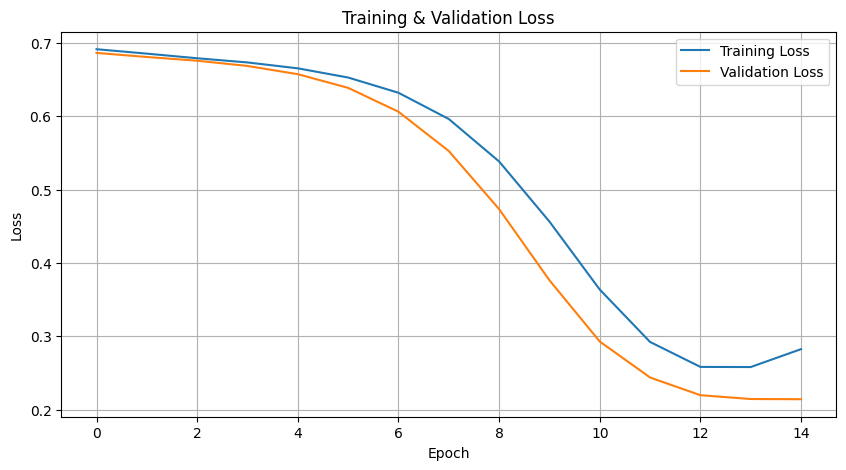

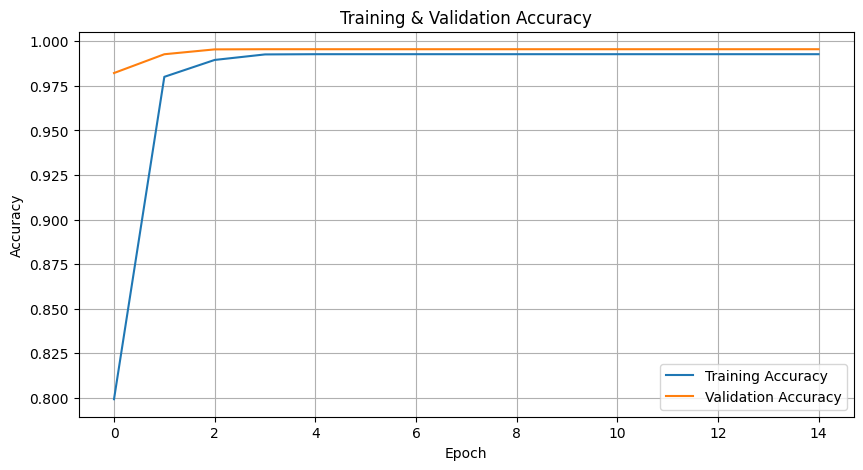

In [ ]:
#accuracy and loss curve

import matplotlib.pyplot as plt

# --- LOSS CURVE ---
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- ACCURACY CURVE ---
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#create a test set of 5 images

original_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen"
output_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned"
preview_folder = "/content/drive/MyDrive/Antarctic_Icebergs/previews_unseen"

preprocess_and_save(original_folder, output_folder, preview_folder)



Processing D33A_003_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned/D33A_003_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews_unseen/D33A_003_reprojected.png

Processing D33A_002_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned/D33A_002_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews_unseen/D33A_002_reprojected.png

Processing D33A_004_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned/D33A_004_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews_unseen/D33A_004_reprojected.png

Processing D33A_005_reprojected.tif ...
Saved cleaned:   /content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned/D33A_005_reprojected.tif
Saved preview:   /content/drive/MyDrive/Antarctic_Icebergs/previews_unseen/D33A_005_reprojected.png

Proc

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/unet_final_model.h5", compile=False)


In [ ]:
import rasterio
import numpy as np
import cv2
import os

def load_unseen_images(image_folder, target_size=(256, 256)):
    images = []
    names = []

    image_files = sorted(os.listdir(image_folder))

    for img_name in image_files:
        img_path = os.path.join(image_folder, img_name)

        try:
            # Use rasterio to read TIFF safely
            with rasterio.open(img_path) as src:
                img = src.read(1)  # read first band

            # Resize
            img_resized = cv2.resize(img, target_size)

            # Normalize + expand dims
            img_normalized = img_resized.astype(np.float32)
            if img_normalized.max() > 1:
              img_normalized = img_normalized / 255.0

            img_expanded = np.expand_dims(img_normalized, axis=-1)

            images.append(img_expanded)
            names.append(img_name)

        except Exception as e:
            print(f"❌ Error loading {img_name}: {e}")

    return np.array(images), names


In [ ]:
X_unseen, names = load_unseen_images("/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unseen_cleaned")

In [ ]:
pred_masks = model.predict(X_unseen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [ ]:
preds_binary = (pred_masks > 0.5).astype(np.uint8)

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(index):
    img = X_unseen[index].squeeze()
    pred = preds_binary[index].squeeze()

    plt.figure(figsize=(10, 5))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original: {names[index]}")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


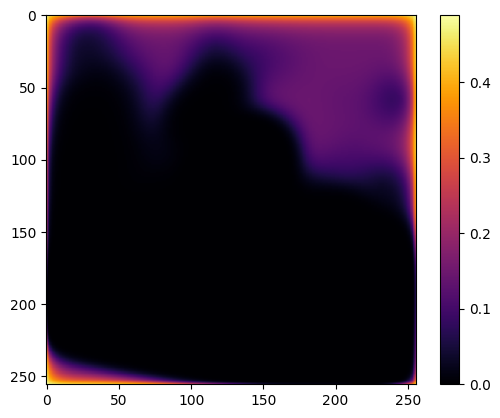

In [ ]:
plt.imshow(pred_masks[0].squeeze(), cmap='inferno')
plt.colorbar()
plt.show()


In [ ]:
print("Training sample stats:")
print("min:", images[0].min(), "max:", images[0].max(), "mean:", images[0].mean())

print("Unseen sample stats:")
print("min:", X_unseen[0].min(), "max:", X_unseen[0].max(), "mean:", X_unseen[0].mean())


Training sample stats:
min: 0.0 max: 1.0 mean: 0.17631929
Unseen sample stats:
min: 0.0 max: 1.0 mean: 0.21455944


In [ ]:

X_unseen.shape


(5, 256, 256, 1)

In [ ]:
model.input_shape


(None, 256, 256, 1)

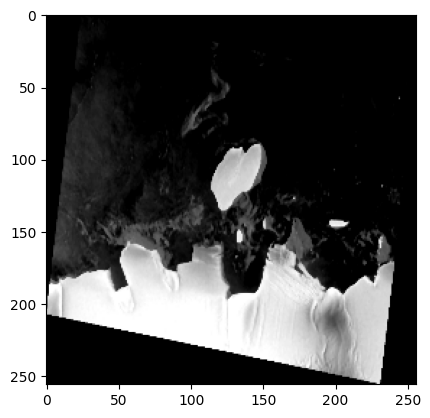

In [ ]:
plt.imshow(X_unseen[0].squeeze(), cmap='gray')
plt.show()


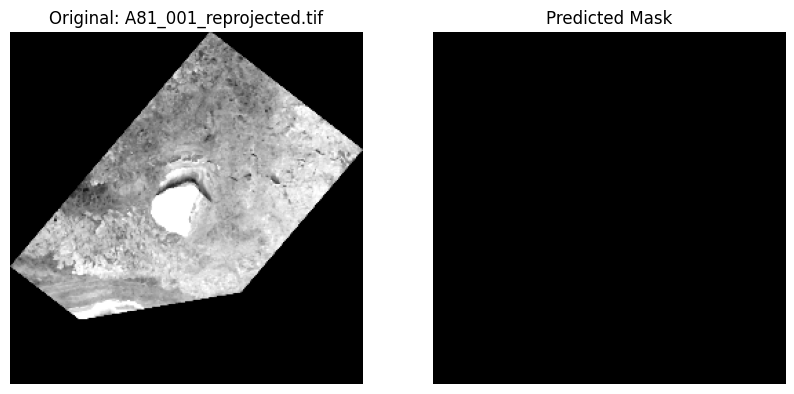

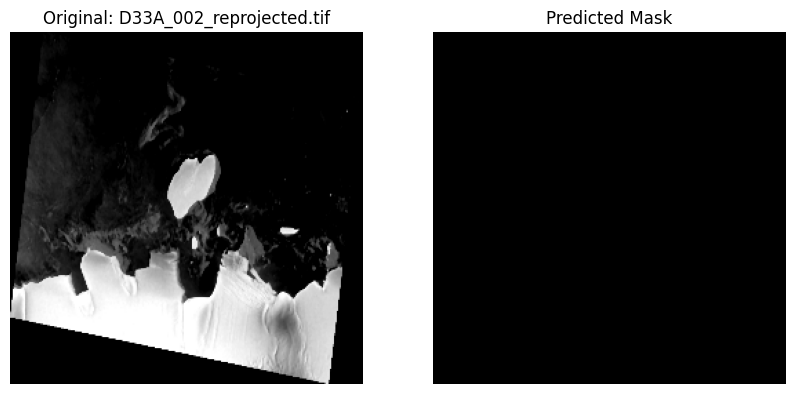

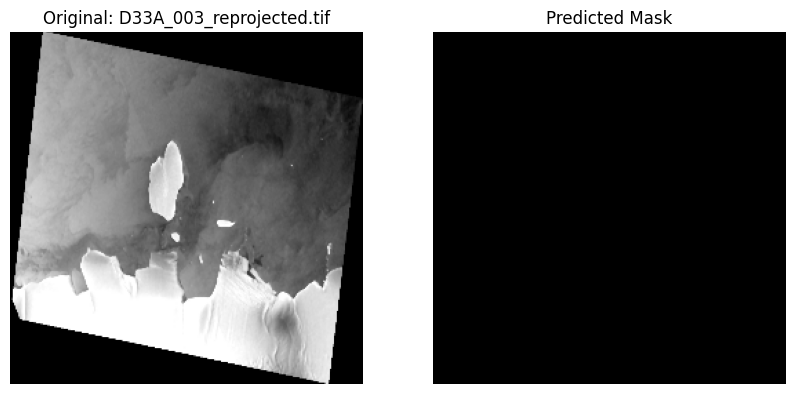

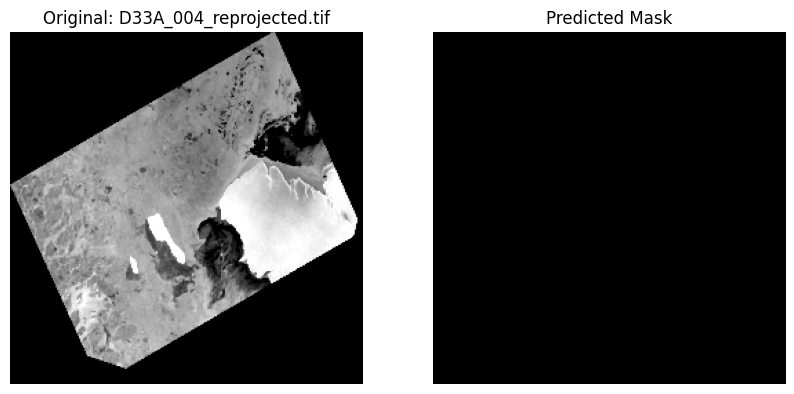

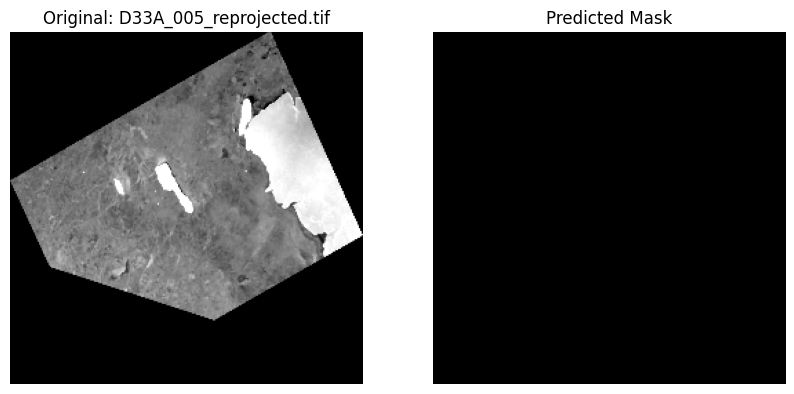

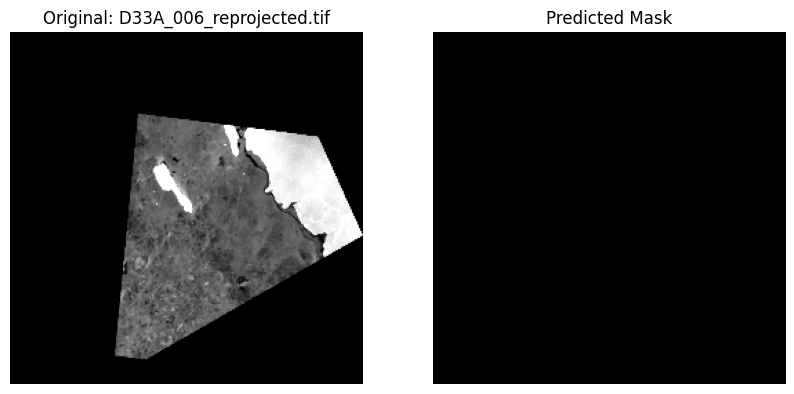

In [ ]:
for i in range(len(X_unseen)):
    visualize_prediction(i)


In [ ]:
#evaluation metrics

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



# -------------------------------
# Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def precision_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positive = tf.reduce_sum(y_true_f * y_pred_f)
    predicted_positive = tf.reduce_sum(y_pred_f)
    return (true_positive + smooth) / (predicted_positive + smooth)


def recall_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positive = tf.reduce_sum(y_true_f * y_pred_f)
    actual_positive = tf.reduce_sum(y_true_f)
    return (true_positive + smooth) / (actual_positive + smooth)


# --------------------------------------------------
# Evaluate model on test dataset
# --------------------------------------------------

def evaluate_model(model, X_test, y_test, threshold=0.5, show_examples=True):
    # Predict
    preds = model.predict(X_test)
    preds_bin = (preds > threshold).astype(np.float32)

    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []

    # Compute metrics per image
    for i in range(len(X_test)):
        iou_scores.append(iou_score(y_test[i], preds_bin[i]).numpy())
        dice_scores.append(dice_coefficient(y_test[i], preds_bin[i]).numpy())
        precision_scores.append(precision_score(y_test[i], preds_bin[i]).numpy())
        recall_scores.append(recall_score(y_test[i], preds_bin[i]).numpy())

    print("\n===== Evaluation Results =====")
    print(f"IoU (Jaccard):      {np.mean(iou_scores):.4f}")
    print(f"Dice Score:         {np.mean(dice_scores):.4f}")
    print(f"Precision:          {np.mean(precision_scores):.4f}")
    print(f"Recall:             {np.mean(recall_scores):.4f}")
    print(f"----------------------------------\n")

    # --------------------------------------------------
    # Show some sample predictions
    # --------------------------------------------------

    if show_examples:
        n_show = 3
        plt.figure(figsize=(12, 12))
        for i in range(n_show):
            idx = np.random.randint(0, len(X_test))

            plt.subplot(n_show, 3, i*3 + 1)
            plt.title("Image")
            plt.imshow(X_test[idx].squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(n_show, 3, i*3 + 2)
            plt.title("Ground Truth Mask")
            plt.imshow(y_test[idx].squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(n_show, 3, i*3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(preds_bin[idx].squeeze(), cmap="gray")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

    return {
        "iou": np.mean(iou_scores),
        "dice": np.mean(dice_scores),
        "precision": np.mean(precision_scores),
        "recall": np.mean(recall_scores)
    }


In [ ]:
results = evaluate_model(model, X_test, y_test)

In [ ]:
# Bootstrapping
# now the model must be trained and evaluated in a variety of ways
# bootstrapping is a great way to test the models bias on a smaller dataset
# statistical evaluation, is there a difference in f1 scores in each sample set?

from sklearn.utils import resample
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_score(y_true, y_pred):
    # convert probability values to binary 0/1 mask using a threshold
    y_pred = (y_pred > 0.4).astype(int)
    y_true = y_true.astype(int)  #ensuring the real mask is also set to int

    # flatten for F1 calculation
    y_true = y_true.flatten()   # scikit-learn expects 1d array
    y_pred = y_pred.flatten()

    return f1_score(y_true, y_pred) # f1 score


n_iterations = 10   # number of bootstrap samples
f1_scores = [] #store all f1 scores

for i in range(n_iterations):
    print(f"\nBootstrap iteration {i+1}/{n_iterations}") # track bootstrapping process

    # create the bootstrap sample
    X_train, y_train = resample(
        images, masks,
        replace=True,
        n_samples=len(images),
        random_state=i #random state ensures a different random sample is generated in every iteration
    )

    # creating train and test sets
    X_train_set = set([id(x) for x in X_train])
    X_test, y_test = [], []
    for img, mask in zip(images, masks):
        if id(img) not in X_train_set:
            X_test.append(img)
            y_test.append(mask)

    # checking the test set isnt empty
    if len(X_test) == 0:
        print("⚠️ All samples used in training; skipping iteration.")
        continue

    # train
    model.fit(
        np.array(X_train), np.array(y_train),
        epochs=10,
        batch_size=4,
        verbose=0
    )

    # test
    predictions = model.predict(np.array(X_test))
    score = calculate_f1_score(np.array(y_test), predictions)
    f1_scores.append(score)

    print(f"F1 Score (iteration {i+1}): {score:.3f}")


print("\nBootstrapping Evaluation Results:")
print(f"Average F1 Score: {np.mean(f1_scores):.3f}")
print(f"Standard Deviation: {np.std(f1_scores):.3f}")



In [ ]:
# K-Fold cross validation
# suitable for small datasets as it uses all the data, will help with generalising to unseen data rather than a sinle train-test set

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np


def calculate_f1_score(y_true, y_pred):
    y_pred = (y_pred > 0.4).astype(int)
    y_true = y_true.astype(int)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return f1_score(y_true, y_pred)


k = 5  # number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42) #create k-fold instance

f1_scores = []

fold = 1
for train_idx, val_idx in kf.split(images): #split sets
    print(f"\n🔹 Fold {fold}/{k}") #print current fold number

    # selecting data for current fold
    X_train, X_val = np.array(images)[train_idx], np.array(images)[val_idx]
    y_train, y_val = np.array(masks)[train_idx], np.array(masks)[val_idx]

    # fresh model for each fold
    model = unet()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # train
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=4,
        verbose=0
    )

    # validation
    predictions = model.predict(X_val)
    score = calculate_f1_score(y_val, predictions)
    f1_scores.append(score)

    print(f"Fold {fold} F1 Score: {score:.3f}")
    fold += 1


print("\nK-Fold Cross Validation Results:")
print(f"Average F1 Score: {np.mean(f1_scores):.3f}")
print(f"Standard Deviation: {np.std(f1_scores):.3f}")


In [ ]:
# black box testing

import numpy as np
import matplotlib.pyplot as plt
import cv2


test_images = "" #add test data

def black_box_tests(model, test_images):
    print("Running black box tests...\n")

    for i, img in enumerate(test_images):
        print(f"Test Case {i+1}")

        # 1. Check prediction shape dimensions
        prediction = model.predict(np.expand_dims(img, axis=0))
        assert prediction.shape[1:3] == img.shape[:2], "Output does not match!" #assert checks if the condition is true otherwise continue
        print("Output shape matches")

        # 2. Check output value range
        assert prediction.min() >= 0 and prediction.max() <= 1, "Output values not normalized (0–1)"
        print("Output normalization test passed")

        # 3. Test with noise/brightness variation
        noisy_img = img + np.random.normal(0, 0.05, img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        noisy_pred = model.predict(np.expand_dims(noisy_img, axis=0))
        diff = np.mean(np.abs(prediction - noisy_pred)) # compares the clean img prediction with the noisy img prediction
        print(f"Output difference with noise: {diff:.4f}")
        if diff < 0.1:
            print("Model robust to noise\n")
        else:
            print("Model sensitive to input noise\n")

        # 4. Visual check
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img.squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Predicted Mask")
        plt.imshow(prediction.squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Noisy Prediction")
        plt.imshow(noisy_pred.squeeze(), cmap='gray')
        plt.show()

# Run test on a few unseen images
black_box_tests(model, test_images[:4])

#test images should include similar images to check consistency with predictions

In [ ]:
#inference time test

import time
import numpy as np

#load and pre-process test img
new_image_path = ""
with rasterio.open(new_image_path) as img_file:
  sample_image = img_file.read(1) # read band
  sample_image = cv2.resize(sample_image, (256, 256))
  sample_image = np.expand_dims(sample_image, axis=-1) / 255.0
  sample_image = np.expand_dims(sample_image, axis=0)

_ = model.predict(img) #the output is irrelevant but the model must be warmed up

def measure_inference_time(model, sample_image, runs=10):
    times = []
    for _ in range(runs):  #ignore the index as we repeat this
        start = time.time()
        _ = model.predict(sample, verbose=0)
        end = time.time()
        times.append(end - start)

    avg_time = np.mean(times)
    std_dev = np.std(times)
    return avg_time, std_dev, times[0]

avg, std, first = measure_inference_time(model, img)

print(f"First inference time: {first*1000:.2f} ms")
print(f"Average inference time over 50 runs: {avg*1000:.2f} ms")
print(f"Standard deviation: {std*1000:.2f} ms")


In [ ]:
# memory usage test

import psutil
import numpy as np
import tensorflow as tf
import time


sample_input = np.random.rand(256, 256, 1).astype('float32')

# Measure memory before inference
process = psutil.Process()
mem_before = process.memory_info().rss / (1024 ** 2)  # in MB


_ = model.predict(dummy_input)

# Measure memory after inference
mem_after = process.memory_info().rss / (1024 ** 2)

print(f"Memory before:  {mem_before:.2f} MB")
print(f"Memory after:   {mem_after:.2f} MB")
print(f"Memory used:    {mem_after - mem_before:.2f} MB")


In [ ]:
# white box testing/ explainability




In [ ]:
# Save the model
model.save("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
import rasterio
import cv2
import numpy as np

# Path to the new image
new_image_path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif"  # Replace with your image path

# Load the image using rasterio
with rasterio.open(new_image_path) as img_file:
    image = img_file.read(1)

# Resize the image to match the model's input shape
image = cv2.resize(image, (256, 256))

# Normalize the image
image = np.expand_dims(image, axis=-1) / 255.0
image = np.expand_dims(image, axis=0)  # Add batch dimension

In [ ]:
# Predict the mask
predicted_mask = model.predict(image)

# Threshold the prediction to get a binary mask
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


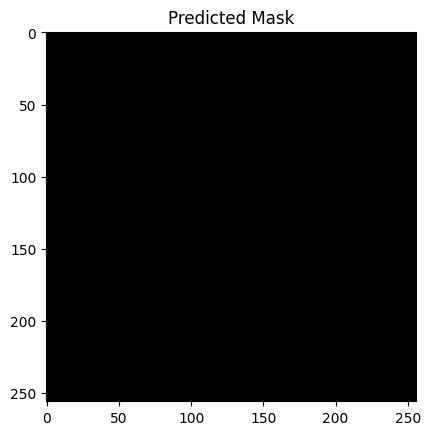

In [ ]:
import matplotlib.pyplot as plt


predicted_mask = predicted_mask.squeeze()

#display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()